# **Sentiment analysis con Embeddings + LSTM**
**Objetivo**

El objetivo es utilizar las críticas de compradores de ropa para que el sistema determine la evaluación del comprador y su crítica (cuantas estrellas le asigna al producto).

In [ ]:
!pip install --upgrade --no-cache-dir gdown --quiet

In [ ]:
import numpy as np
import random
import io
import pickle
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from tensorflow.keras import layers

from keras.utils.np_utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding

from sklearn.metrics import roc_curve

# **Datos**
Utilizaremos como dataset críticas de compradores de ropa (eCommerce) los cuales puntuaron a cada prenda con un puntaje de 1 a 5 estrellas.\ Referencia del dataset: LINK

In [ ]:
# Descargar la carpeta de dataset
import os
import gdown
if os.access('clothing_ecommerce_reviews.csv', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1k2Dz4oY5uxI3JEaT6m-L2T2HvLkECYIP'
    output = 'clothing_ecommerce_reviews.csv'
    gdown.download(url, output, quiet=False)
else:
    print("El dataset ya se encuentra descargado")

El dataset ya se encuentra descargado


In [ ]:
# Armar el dataset
df = pd.read_csv('clothing_ecommerce_reviews.csv')
df.drop(columns = ['Unnamed: 0'], inplace = True)
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


## **1 - Limpieza de datos**
Alumno:

*   Del dataset unicamente utilizar las columnas "Review Text" y "Rating.
*   Tranformar el rating 1-5 a una escala numérica de 0 a 4.



In [ ]:
df_reviews = df.loc[:, ['Review Text', 'Rating']].dropna()
df_reviews['Rating'] = df_reviews['Rating'] - 1
df_reviews.head()

,Review Text,Rating
0,Absolutely wonderful - silky and sexy and comf...,3
1,Love this dress! it's sooo pretty. i happene...,4
2,I had such high hopes for this dress and reall...,2
3,"I love, love, love this jumpsuit. it's fun, fl...",4
4,This shirt is very flattering to all due to th...,4


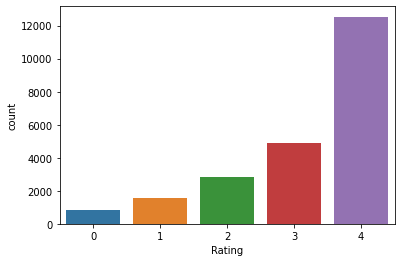

In [ ]:
# Alumno: Observar como está distribuido el dataset respecto a la columna Rating
# es decir, observar que tan balanceado se encuentra respecot a cada clase

sns.countplot(x="Rating", data=df_reviews)

## **Estrategia**
Como se observar en el gráfico el conjunto de datos está muy desbalanceado por lo tanto lo recomendable en estos casos de clasificación multiclases sería utilizar alguna estrategia para mejorar esta situación. A los efectos del trabajo práctico no voy a aplicar ninguna de las estratégias de balanceo del dataset, voy a trabajar con los datos cómo están para confirmar en base a los resultados la necesidad de aplicar dichas estratégias.



In [ ]:
# Alumno: tomar la columna de las review y almacenarlo todo en un vector numpy de reviews
text_sequences = df_reviews["Review Text"].values
text_sequences.shape

(22641,)

In [ ]:
# Cuantas reviews (rows) hay para evaluar?
len(text_sequences)

22641

In [ ]:
# Alumno: Concatenar todas las reviews para armar el corpus
# Concatenar todas las reviews para armar el corpus
corpus = ' '.join(text_sequences)

In [ ]:
# ¿Cuál es la longitud de ese corpus?
len(corpus)

7011643

In [ ]:
# Utilizar "text_to_word_sequence" para separar las palabras en tokens
# recordar que text_to_word_sequence automaticamente quita los signos de puntuacion y pasa el texto a lowercase
from keras.preprocessing.text import text_to_word_sequence
tokens = text_to_word_sequence(corpus)

In [ ]:
# Dar un vistazo a los primeros 20 tokens/palabras
tokens[:20]

['absolutely',
 'wonderful',
 'silky',
 'and',
 'sexy',
 'and',
 'comfortable',
 'love',
 'this',
 'dress',
 "it's",
 'sooo',
 'pretty',
 'i',
 'happened',
 'to',
 'find',
 'it',
 'in',
 'a']

In [ ]:
# ¿Cuántos tokens/palabras hay?
len(tokens)

1372203

In [ ]:
len(set(tokens))

14847

In [ ]:
# Tokenizar las palabras con el Tokenizer de Keras
# Definir una máxima cantidad de palabras a utilizar:
# - num_words --> the maximum number of words to keep, based on word frequency.
# - Only the most common num_words-1 words will be kept.
from keras.preprocessing.text import Tokenizer
num_words = 10000
vocab_size = num_words
tok = Tokenizer(num_words=10000) 
tok.fit_on_texts(tokens)

In [ ]:
# Obtener el diccionario de palabra (word) a índice
# y observar la cantidad total del vocabulario
word_index = tok.word_index
len(word_index)

14847

In [ ]:
# Convertir las palabras/tokens a números
sequences = tok.texts_to_sequences(text_sequences)

In [ ]:
sequences[0][:10]

[253, 532, 917, 3, 662, 3, 68]

In [ ]:
# Determinar cual es la oración más larga
max(len(s) for s in sequences)

116

In [ ]:
#from numpy.ma.core import append
largo = []
for s in sequences:
    largo.append(len(s))
print(largo)    

[7, 62, 97, 22, 36, 98, 99, 97, 34, 73, 66, 8, 95, 75, 96, 96, 73, 57, 33, 57, 64, 105, 85, 41, 95, 69, 98, 47, 32, 85, 17, 66, 18, 86, 52, 18, 29, 71, 16, 23, 26, 50, 47, 96, 73, 46, 39, 10, 16, 47, 69, 37, 9, 90, 84, 41, 86, 30, 100, 51, 57, 100, 39, 22, 12, 44, 104, 97, 70, 55, 89, 102, 103, 51, 109, 99, 58, 39, 51, 86, 102, 10, 92, 97, 104, 102, 77, 106, 21, 77, 83, 81, 94, 97, 49, 32, 89, 47, 90, 46, 31, 13, 58, 52, 62, 63, 7, 32, 105, 89, 40, 93, 12, 36, 62, 84, 66, 25, 54, 60, 39, 40, 93, 88, 87, 31, 30, 103, 93, 70, 53, 91, 83, 76, 99, 76, 45, 56, 39, 40, 103, 83, 47, 84, 78, 30, 22, 62, 43, 106, 41, 53, 78, 55, 92, 86, 89, 102, 40, 99, 48, 30, 97, 25, 38, 92, 76, 61, 52, 65, 46, 91, 99, 35, 89, 92, 52, 67, 100, 33, 18, 85, 40, 43, 50, 22, 25, 89, 101, 66, 14, 40, 49, 50, 41, 104, 82, 56, 72, 90, 38, 23, 65, 100, 48, 49, 90, 29, 100, 25, 11, 105, 34, 91, 95, 61, 100, 28, 66, 96, 72, 88, 76, 81, 96, 45, 31, 32, 34, 90, 95, 36, 90, 42, 70, 55, 31, 54, 92, 10, 78, 35, 57, 47, 38, 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


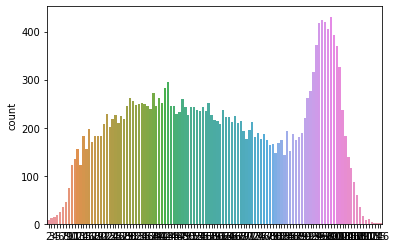

In [ ]:
sns.countplot(largo)

In [ ]:
# Realizar padding de las sentencias al mismo tamaño
# tomando de referencia la máxima sentencia
from keras.preprocessing.sequence import pad_sequences
maxlen = 116

# Al realizar padding obtener la variable "X" (input)
X = pad_sequences(sequences, padding='pre', maxlen=maxlen)

In [ ]:
# Observar las dimensiones de la variable input
X.shape

(22641, 116)

In [ ]:
# Tomar la columna rating y alcemacenarla en una variable "y"
# Su shape debe ser equivalente la cantidad de rows del corpus
y = df_reviews['Rating'].values
print(y.shape)

(22641,)


# **Tratamiento del desbalanceo del dataset**

En lugar de agrupar categorías para balancer el dataset voy a probar como se comporta si mantenemos las categorías como están pero al hacer el split utilizamos el parámetor "strafify" que mantiene las proporciones de las categorías en ambos conjuntos.

In [ ]:
# Dividir los datos en train y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [ ]:
y_train_trans = to_categorical(y_train)
y_test_trans = to_categorical(y_test)

In [ ]:
# Determinar la dimensiones de entrada y salida
in_shape = X_train.shape[1] # max input sentence len
out_shape = 5 # binary classification
print("in_shape", in_shape, ", out_shape", out_shape)

in_shape 116 , out_shape 5


In [ ]:
# Entrenar un modelo con LSTM entrenando sus propios embeddings
# o utilizando embeddings pre-entrenados.
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout

model = Sequential()
# input_dim = vocab_size (max n_words)
# input_length = setencias con padding a 200
# output_dim = 50 --> crear embeddings de tamaño 50
model.add(Embedding(input_dim=vocab_size+1, output_dim=50, input_length=in_shape))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=64)) # La última capa LSTM no lleva return_sequences

model.add(Dense(units=128, activation='relu'))
model.add(Dropout(rate=0.2))
model.add(Dense(units=out_shape, activation='softmax'))

model.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 116, 50)           500050    
                                                                 
 lstm_6 (LSTM)               (None, 116, 64)           29440     
                                                                 
 dropout_6 (Dropout)         (None, 116, 64)           0         
                                                                 
 lstm_7 (LSTM)               (None, 64)                33024     
                                                                 
 dense_6 (Dense)             (None, 128)               8320      
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_7 (Dense)             (None, 5)                

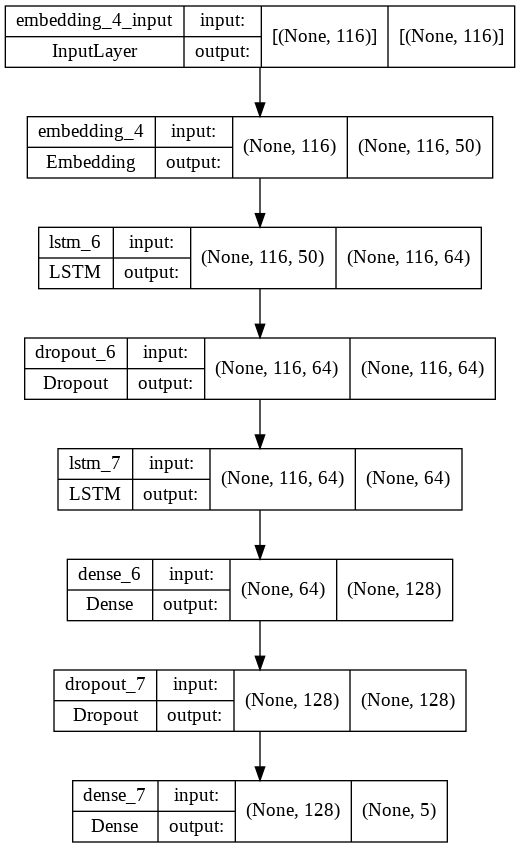

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
hist = model.fit(X_train, y_train_trans, epochs=20, validation_split=0.2)

Epoch 1/20
453/453 [==============================] - 86s 180ms/step - loss: 1.0266 - accuracy: 0.5958 - val_loss: 0.9072 - val_accuracy: 0.6235
Epoch 2/20
453/453 [==============================] - 83s 184ms/step - loss: 0.8534 - accuracy: 0.6456 - val_loss: 0.8709 - val_accuracy: 0.6329
Epoch 3/20
453/453 [==============================] - 82s 181ms/step - loss: 0.7554 - accuracy: 0.6795 - val_loss: 0.9006 - val_accuracy: 0.6274
Epoch 4/20
453/453 [==============================] - 81s 178ms/step - loss: 0.6707 - accuracy: 0.7230 - val_loss: 0.9526 - val_accuracy: 0.6014
Epoch 5/20
453/453 [==============================] - 80s 177ms/step - loss: 0.5982 - accuracy: 0.7593 - val_loss: 1.0388 - val_accuracy: 0.6014
Epoch 6/20
453/453 [==============================] - 82s 181ms/step - loss: 0.5362 - accuracy: 0.7883 - val_loss: 1.1299 - val_accuracy: 0.6130
Epoch 7/20
453/453 [==============================] - 86s 189ms/step - loss: 0.4742 - accuracy: 0.8177 - val_loss: 1.2282 - val_ac

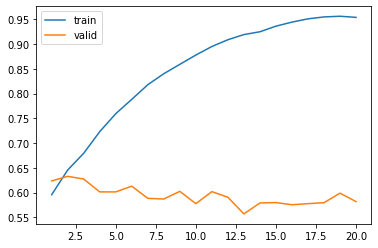

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist.history['val_accuracy'], label='valid')
plt.show()

In [ ]:
model.evaluate(X_test, y_test_trans)

142/142 [==============================] - 5s 36ms/step - loss: 2.1872 - accuracy: 0.5891


[2.187199831008911, 0.589092493057251]

# **Conclusión 1:**
Como se observa en la figura, en train el modelo hace overfitting y en validación el desempeño es muy pobre. 

Hice varias pruebas modificando y combinando diferentes parámetros:


*   Tokenizer con 2000, 4000, 8000 y 10000 palábras
*   Tamaño de sentencias de 200 y 116
*   Cantidad de epoch de 5, 10  y 20
*   OneHotEncoding de la variable "y" antes y despues del split stratify

Para todos los casos el resultado fue muy parecido, en entrenamiento hace overfitting y en validación el resultado es muy pobre, cercano al 0,6 de accuracy.

Entonces en principio se podría concluir que no es una estrategia válida y que tendría que buscar balancear el dataset agrupando las categorías para lograr un mejor desempeño.

Por último voy a probar si utilizando embeddings pre-entrenados sobre el modelo multiclase se consiguen mejores resultados.



In [ ]:
# Descargar los embeddings desde un gogle drive (es la forma más rápida)
# NOTA: No hay garantía de que estos links perduren, en caso de que no estén
# disponibles descargar de la página oficial como se explica en el siguiente bloque
import os
import gdown
if os.access('fasttext.pkl', os.F_OK) is False:
    url = 'https://drive.google.com/uc?id=1KU5qmAYh3LATMvVgocFDfW-PK3prm1WU&export=download'
    output = 'fasttext.pkl'
    gdown.download(url, output, quiet=False)
else:
    print("Los embeddings fasttext.pkl ya están descargados")

Los embeddings fasttext.pkl ya están descargados


In [ ]:
import logging
import os
from pathlib import Path
from io import StringIO
import pickle

class WordsEmbeddings(object):
    logger = logging.getLogger(__name__)

    def __init__(self):
        # load the embeddings
        words_embedding_pkl = Path(self.PKL_PATH)
        if not words_embedding_pkl.is_file():
            words_embedding_txt = Path(self.WORD_TO_VEC_MODEL_TXT_PATH)
            assert words_embedding_txt.is_file(), 'Words embedding not available'
            embeddings = self.convert_model_to_pickle()
        else:
            embeddings = self.load_model_from_pickle()
        self.embeddings = embeddings
        # build the vocabulary hashmap
        index = np.arange(self.embeddings.shape[0])
        # Dicctionarios para traducir de embedding a IDX de la palabra
        self.word2idx = dict(zip(self.embeddings['word'], index))
        self.idx2word = dict(zip(index, self.embeddings['word']))

    def get_words_embeddings(self, words):
        words_idxs = self.words2idxs(words)
        return self.embeddings[words_idxs]['embedding']

    def words2idxs(self, words):
        return np.array([self.word2idx.get(word, -1) for word in words])

    def idxs2words(self, idxs):
        return np.array([self.idx2word.get(idx, '-1') for idx in idxs])

    def load_model_from_pickle(self):
        self.logger.debug(
            'loading words embeddings from pickle {}'.format(
                self.PKL_PATH
            )
        )
        max_bytes = 2**28 - 1 # 256MB
        bytes_in = bytearray(0)
        input_size = os.path.getsize(self.PKL_PATH)
        with open(self.PKL_PATH, 'rb') as f_in:
            for _ in range(0, input_size, max_bytes):
                bytes_in += f_in.read(max_bytes)
        embeddings = pickle.loads(bytes_in)
        self.logger.debug('words embeddings loaded')
        return embeddings

    def convert_model_to_pickle(self):
        # create a numpy strctured array:
        # word     embedding
        # U50      np.float32[]
        # word_1   a, b, c
        # word_2   d, e, f
        # ...
        # word_n   g, h, i
        self.logger.debug(
            'converting and loading words embeddings from text file {}'.format(
                self.WORD_TO_VEC_MODEL_TXT_PATH
            )
        )
        structure = [('word', np.dtype('U' + str(self.WORD_MAX_SIZE))),
                     ('embedding', np.float32, (self.N_FEATURES,))]
        structure = np.dtype(structure)
        # load numpy array from disk using a generator
        with open(self.WORD_TO_VEC_MODEL_TXT_PATH, encoding="utf8") as words_embeddings_txt:
            embeddings_gen = (
                (line.split()[0], line.split()[1:]) for line in words_embeddings_txt
                if len(line.split()[1:]) == self.N_FEATURES
            )
            embeddings = np.fromiter(embeddings_gen, structure)
        # add a null embedding
        null_embedding = np.array(
            [('null_embedding', np.zeros((self.N_FEATURES,), dtype=np.float32))],
            dtype=structure
        )
        embeddings = np.concatenate([embeddings, null_embedding])
        # dump numpy array to disk using pickle
        max_bytes = 2**28 - 1 # # 256MB
        bytes_out = pickle.dumps(embeddings, protocol=pickle.HIGHEST_PROTOCOL)
        with open(self.PKL_PATH, 'wb') as f_out:
            for idx in range(0, len(bytes_out), max_bytes):
                f_out.write(bytes_out[idx:idx+max_bytes])
        self.logger.debug('words embeddings loaded')
        return embeddings


class GloveEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'glove.twitter.27B.50d.txt'
    PKL_PATH = 'gloveembedding.pkl'
    N_FEATURES = 50
    WORD_MAX_SIZE = 60


class FasttextEmbeddings(WordsEmbeddings):
    WORD_TO_VEC_MODEL_TXT_PATH = 'cc.en.300.vec'
    PKL_PATH = 'fasttext.pkl'
    N_FEATURES = 300
    WORD_MAX_SIZE = 60

In [ ]:
model_fasttext = FasttextEmbeddings()

In [ ]:
# Crear la Embedding matrix

print('preparing embedding matrix...')
embed_dim = 300 # fasttext
words_not_found = []

# word_index provieen del tokenizer

nb_words = min(num_words, len(word_index)) # vocab_size
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = model_fasttext.get_words_embeddings(word)[0]
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        embedding_matrix[i] = embedding_vector
    else:
        # words not found in embedding index will be all-zeros.
        words_not_found.append(word)
        print(word)

print('number of null word embeddings:', np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 2


In [ ]:
Embedding(input_dim=vocab_size,  # definido en el Tokenizador
          output_dim=embed_dim,  # dimensión de los embeddings utilizados
          input_length=in_shape, # máxima sentencia de entrada
          weights=[embedding_matrix],  # matrix de embeddings
          trainable=False)      # marcar como layer no entrenable

In [ ]:
model2 = Sequential()
# input_dim = vocab_size (max n_words)
# input_length = setencias con padding a 200
# output_dim = embed_dim (depende que embeddings pre entrenados utilizamos)
model2.add(Embedding(input_dim=vocab_size, output_dim=embed_dim, input_length=in_shape,
                     weights=[embedding_matrix], trainable=False))

model2.add(LSTM(units=64, return_sequences=True))
model2.add(Dropout(0.2))
model2.add(LSTM(units=64)) # La última capa LSTM no lleva return_sequences

model2.add(Dense(units=128, activation='relu'))
model2.add(Dropout(rate=0.2))
model2.add(Dense(units=out_shape, activation='softmax'))

model2.compile(optimizer="adam",
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_6 (Embedding)     (None, 116, 300)          3000000   
                                                                 
 lstm_8 (LSTM)               (None, 116, 64)           93440     
                                                                 
 dropout_8 (Dropout)         (None, 116, 64)           0         
                                                                 
 lstm_9 (LSTM)               (None, 64)                33024     
                                                                 
 dense_8 (Dense)             (None, 128)               8320      
                                                                 
 dropout_9 (Dropout)         (None, 128)               0         
                                                                 
 dense_9 (Dense)             (None, 5)                

In [ ]:
hist2 = model2.fit(X_train, y_train_trans, epochs=20, validation_split=0.2)

Epoch 1/20
453/453 [==============================] - 93s 195ms/step - loss: 1.2189 - accuracy: 0.5535 - val_loss: 1.2314 - val_accuracy: 0.5506
Epoch 2/20
453/453 [==============================] - 88s 195ms/step - loss: 1.1737 - accuracy: 0.5555 - val_loss: 1.1553 - val_accuracy: 0.5518
Epoch 3/20
453/453 [==============================] - 90s 198ms/step - loss: 1.1469 - accuracy: 0.5577 - val_loss: 1.1362 - val_accuracy: 0.5584
Epoch 4/20
453/453 [==============================] - 88s 193ms/step - loss: 1.1222 - accuracy: 0.5629 - val_loss: 1.1193 - val_accuracy: 0.5653
Epoch 5/20
453/453 [==============================] - 87s 192ms/step - loss: 1.1036 - accuracy: 0.5650 - val_loss: 1.1110 - val_accuracy: 0.5669
Epoch 6/20
453/453 [==============================] - 90s 198ms/step - loss: 1.0796 - accuracy: 0.5732 - val_loss: 1.1116 - val_accuracy: 0.5526
Epoch 7/20
453/453 [==============================] - 94s 208ms/step - loss: 1.0569 - accuracy: 0.5766 - val_loss: 1.0889 - val_ac

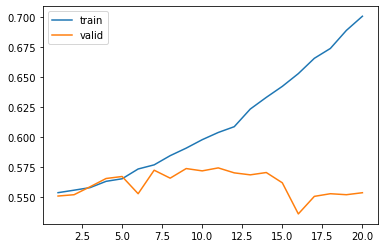

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
epoch_count = range(1, len(hist2.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist2.history['accuracy'], label='train')
sns.lineplot(x=epoch_count,  y=hist2.history['val_accuracy'], label='valid')
plt.show()

In [ ]:
model2.evaluate(X_test, y_test_trans)

142/142 [==============================] - 8s 53ms/step - loss: 1.2955 - accuracy: 0.5637


[1.295513391494751, 0.5637006163597107]

## **Conclusión 2:**

Luego de 20 epoch se puede observar que el accuracy en validación es similar en ambos casos, muy bajo, pero el comportamiento en entrenamiento es muy diferente. En el caso donde entreno el embedding muy rápidamente hace overfitting mientras que cuando trabajo con un embedding pre-entrenado tiende al overfitting pero de manera mucho mas suave.

Otra diferencia es que en validación el mayor accuracy es de 0,63 cuando se entrenan los embedding y de 0,57 cuando se trabaja con embedding pre-entrenados.

Como conclusión final se podría decir, como se presuponía, que el desbalanceo del dataset no va a permitir conseguir un buen desempeño de los modelos independientemente de utilizar un embedding pre-entrenado o entrenándolo. 

Por último, los resultados demuestran que cuando se tienen dataset muy desbalanceado no es buena estrategia mantener el desbalanceo para entrenar modelos.